In [5]:
from transformers import ESMForMaskedLM, ESMTokenizer, pipeline
#https://discuss.huggingface.co/t/solved-model-esm-1b-is-not-defined/17104
import pandas as pd
import numpy as np
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import torch
import math
import utilities
import pickle

In [3]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [4]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [7]:
# mask amino acid, take BCE loss of softmax(predicted) from actual, average for all amino acid of same type, compare across
aa_loss = {}
aa_counts = {}
for i in range(100):
    seq = fastas[seqids[i]]["sequence"]
    if len(seq) > 1000: continue
    seq_list = utilities.mask_seq(seq)
    #for temp_seq in seq_list:
    #get all logit for entire sequence
    results = None
    for x in range(0, len(seq_list), 10):
        temp_result = utilities.forward_pass(model, alphabet, seq_list[x:x+10])
        if results == None:
            results = temp_result
        else:
            results = torch.concat((results, temp_result), dim=0)
        #print(results.shape)
        #if i == 10: break
    #print(results)
    # go through, subset to just maxed amino acid, softmax of predicted layer, BCE with real
    for j, result in enumerate(results):
        masked_aa = seq[j]
        correct_row = result[j+1]
        softmax = torch.nn.Softmax(dim=-1)
        soft_row = softmax(correct_row)
        bce = torch.nn.CrossEntropyLoss()
        target = torch.tensor([alphabet.tok_to_idx[masked_aa]])
        loss = bce(torch.reshape(soft_row, (1,33)), target)
        try:
            aa_loss[masked_aa] += float(loss)
        except KeyError:
            aa_loss[masked_aa] = float(loss)
        
        try:
            aa_counts[masked_aa] += 1
        except KeyError:
            aa_counts[masked_aa] = 1
    
    if i % 5 == 0:
        with open('loss.pickle', 'wb') as handle:
            pickle.dump(aa_loss, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        with open('counts.pickle', 'wb') as handle:
            pickle.dump(aa_counts, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        print(i)
    #print(results)



0



KeyboardInterrupt



In [8]:
aa_counts

{'M': 6,
 'A': 13,
 'F': 8,
 'S': 13,
 'E': 15,
 'D': 17,
 'V': 21,
 'L': 25,
 'K': 29,
 'Y': 14,
 'R': 15,
 'P': 11,
 'N': 8,
 'W': 4,
 'Q': 9,
 'C': 4,
 'G': 15,
 'I': 12,
 'H': 9,
 'T': 8}

In [9]:
np.array(list(aa_loss.values()))/np.array(list(aa_counts.values()))

array([3.34999752, 3.46088899, 3.47518232, 3.45960436, 3.43095584,
       3.4425231 , 3.45697871, 3.42501501, 3.44108745, 3.49477826,
       3.46035689, 3.46724397, 3.47952881, 3.50798506, 3.4889537 ,
       3.51529557, 3.46192379, 3.46121685, 3.49686797, 3.47002906])

In [12]:
aa_loss

{'M': 20.099985122680664,
 'A': 44.991556882858276,
 'F': 27.801458597183228,
 'S': 44.97485661506653,
 'E': 51.46433758735657,
 'D': 58.52289271354675,
 'V': 72.59655284881592,
 'L': 85.6253752708435,
 'K': 99.79153609275818,
 'Y': 48.92689561843872,
 'R': 51.905353307724,
 'P': 38.13968372344971,
 'N': 27.836230516433716,
 'W': 14.031940221786499,
 'Q': 31.400583267211914,
 'C': 14.061182260513306,
 'G': 51.92885684967041,
 'I': 41.53460216522217,
 'H': 31.471811771392822,
 'T': 27.76023244857788}

In [8]:
results[0].shape

torch.Size([258, 33])

Text(0, 0.5, 'Average Cross Entropy')

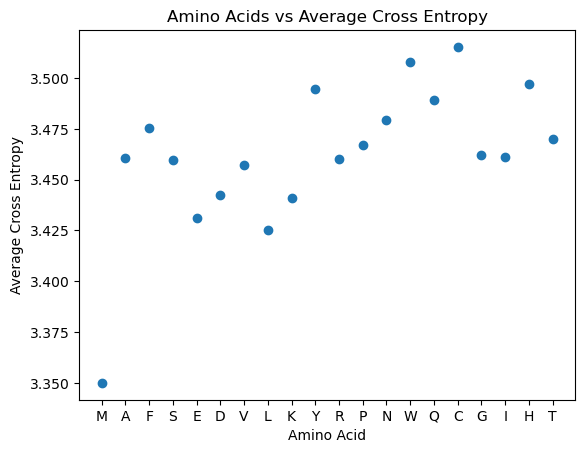

In [15]:
plt.scatter(aa_counts.keys(), np.array(list(aa_loss.values()))/np.array(list(aa_counts.values())))
plt.title("Amino Acids vs Average Cross Entropy")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")

In [11]:
[("blah", x) for x in seq_list][0]

'<mask>AFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

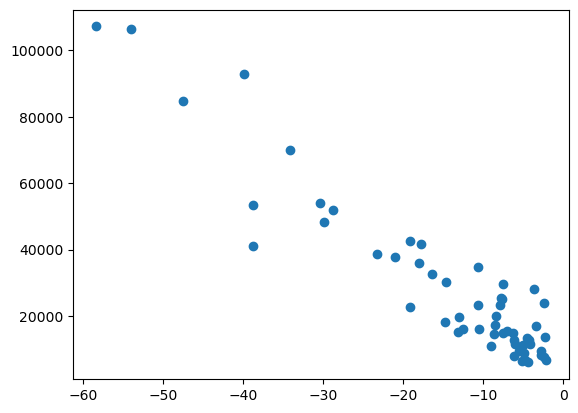

In [41]:
plt.scatter(seq_probs, analysis[0:56,0])

In [30]:
seq_length = np.array(seq_length)

In [66]:
seq_probs = np.array(seq_probs)
seq_probs_norm = seq_probs / np.floor(seq_length/20)[0:56]

TypeError: unsupported operand type(s) for /: 'list' and 'int'

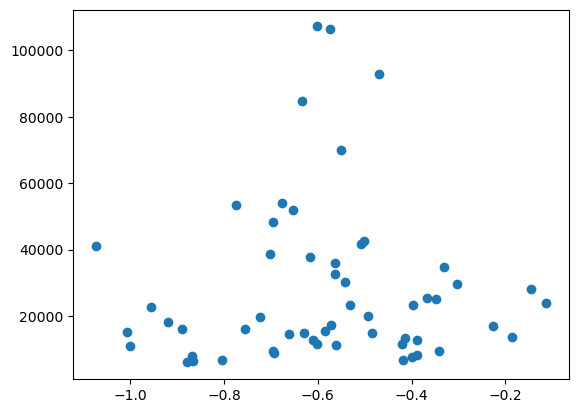

In [43]:
plt.scatter(seq_probs_norm, analysis[0:56,0])

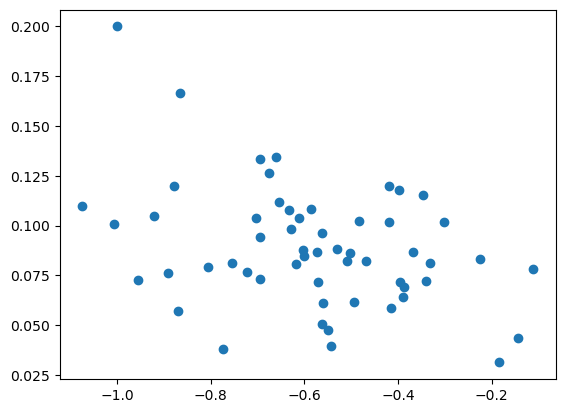

In [49]:
#aromaticity
plt.scatter(seq_probs_norm, analysis[0:56,3])

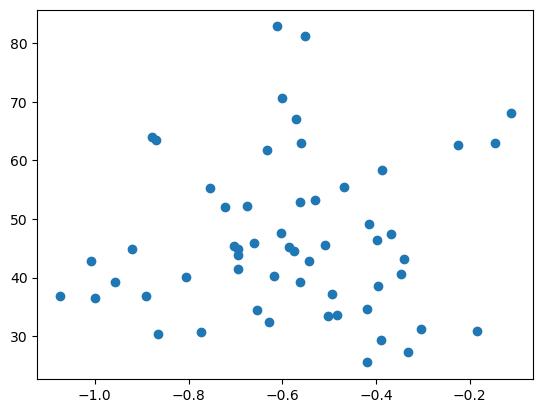

In [53]:
plt.scatter(seq_probs_norm, analysis[0:56,5])